In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('X_train.csv')
raw_data = raw_data.rename(columns={'reting':'rating'})
raw_data.head()

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,rating,date,comment,commentNegative,commentPositive
0,20005023,401,4010201,826,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",NaN,NaN
1,20020647,403,4030101,1425,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",538c73d64461e13907bb95c51c38bfbc,2.0,2010-07-04,Через 2 месяца после истечении гарантийного ср...,NaN,NaN
2,20020701,401,4010401,124,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",ddca2d0101513a6209db7868eed8be05,4.0,2010-05-27,пользуюсь уже три недели. нареканий ни каких н...,NaN,NaN
3,30012256,203,2030301,93,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",289c20015b3713a82ba5ddf774d996f7,5.0,2016-10-11,Ребят этот системный блок подойдёт для игры кс...,NaN,NaN
4,30011341,205,2050201,656,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",5576f82d149d4f688644fef2322c63ef,5.0,2010-02-26,"я считаю, что яри замечательный телефон! Прият...",NaN,NaN


In [3]:
raw_data.shape

(15587, 11)

In [4]:
raw_data.isnull().any()

sku                 False
categoryLevel1Id    False
categoryLevel2Id    False
brandId             False
property            False
userName            False
rating              False
date                False
comment             False
commentNegative      True
commentPositive      True
dtype: bool

# 1. Данные:

### ~15000 отзывов 3232 юзеров о 2698 товарах.
### Имеем 11 полей:

sku - уникальный id товара (2698).

categoryLevel1Id - "глобальный" тип товара(компьютеры(203), встраиваемая техника для кухни(401), стиральные машины(403), смартфоны(205), etc) (всего - 48).

categoryLevel2Id - подтип товара (для кухни, к примеру - вытяжки, холодильники, посудомойки, etc) (в среднем - по 3-4 на один тип).

brandId - бренд (193).

property - ?? владелец брэнда (2502).

userName - имя пользователя (3232).

rating - предсказываемый рейтинг (целое от 1 до 5).

date - дата.

comment Positive/comment Negative/comment - строка преимуществ/строка недостатков/непустой отзыв.


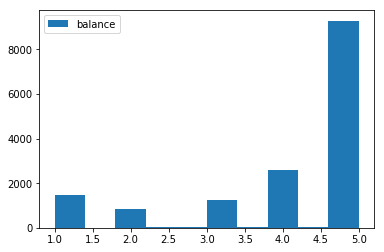

In [5]:
bins = sorted(raw_data['rating'].unique())
plt.hist(raw_data['rating'], label='balance')
plt.legend(loc='best')
plt.show()

In [6]:
def show_frequences(data):
    frequences = []
    bins = sorted(data['rating'].unique())
    for rate in bins:
        frequences += [data[raw_data['rating'] == rate].shape[0]]
    frequences = np.array(frequences)
    print('Percent of objects in class:')
    for i, rate in enumerate(bins):
        print(rate, '-', round(100*frequences[i]/np.sum(frequences), 2),'%')
show_frequences(raw_data)

Percent of objects in class:
1.0 - 9.42 %
1.3 - 0.04 %
1.7 - 0.01 %
2.0 - 5.48 %
2.3 - 0.09 %
2.7 - 0.1 %
3.0 - 7.99 %
3.3 - 0.1 %
3.7 - 0.1 %
4.0 - 16.74 %
4.3 - 0.35 %
4.7 - 0.5 %
5.0 - 59.09 %


Выборка сильно несбалансированная.
Учитывая незначительность числа дробных оценок, округляем всё до целого, и решаем задачу 5-классовой классификации.

In [7]:
raw_data = raw_data.fillna('')
raw_data['rating'] = raw_data['rating'].astype(int)
show_frequences(raw_data)

Percent of objects in class:
1 - 9.46 %
2 - 5.66 %
3 - 8.19 %
4 - 17.59 %
5 - 59.09 %


In [8]:
other_usefull_columns = ['sku', 'categoryLevel1Id', 'property', 
                   'categoryLevel2Id', 'brandId']
data_0 = raw_data['comment'].str.cat(raw_data['commentNegative'], sep=' ')
data_0 = data_0.str.cat(raw_data['commentPositive'], sep=' ')
data_1 = raw_data[other_usefull_columns]
target = raw_data['rating']

In [9]:
def remove_delimiters(data, listOfItems):
    ans = data
    for item in listOfItems:
        ans = ans.str.replace(item, ' ')
    return ans
data_0 = remove_delimiters(data_0, ['.', ',', '!', '\d+', '\s+'])

In [10]:
data_0.head()

0     года работала и все устала Лампочка горит и б...
1    Через месяца после истечении гарантийного срок...
2    пользуюсь уже три недели нареканий ни каких не...
3    Ребят этот системный блок подойдёт для игры кс...
4    я считаю что яри замечательный телефон Приятно...
Name: comment, dtype: object

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_0, target, 
                                                    test_size=0.3, random_state=6)

# 2. Обучение:

Пробуем воспользоваться стандартной Support Vector Classification только по отзывам.
Для этого векторизуем слова и перебираем параметры по сетке.


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [14]:
pipe = Pipeline([('cvec', CountVectorizer(min_df=5)), 
                 ('tfidf', TfidfTransformer())])

In [15]:
X_train = pipe.fit_transform(X_train)

In [17]:
parameters = {'kernel':('linear', 'rbf'), 'C':(1, 5)}

In [16]:
parameters = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':(1, 2, 5)}

In [18]:
text_classifier = GridSearchCV(SVC(class_weight='balanced', cache_size=4000), param_grid=parameters)

In [19]:
X_test = pipe.transform(X_test)

In [20]:
text_classifier = text_classifier.fit(X_train, y_train)

In [21]:
text_classifier.best_estimator_

SVC(C=5, cache_size=4000, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
predicted = text_classifier.predict(X_test)

# 3. Результаты:
Построим гистограмму распределений ответов по классам (она должна примерно совпадать с гистограммой количества)
и посчитаем основные метрики качества.

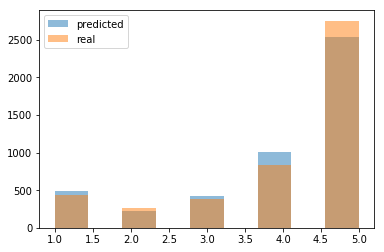

In [24]:
bins = np.linspace(1,5,10)
plt.hist(predicted, bins, alpha=0.5, label='predicted')
plt.hist(y_test, bins, alpha=0.5, label='real')
plt.legend(loc='best')
plt.show()

In [25]:
empty = {'True Positive': pd.Series(np.zeros(6)), 
        'False Positive': pd.Series(np.zeros(6)),
        'False Negative': pd.Series(np.zeros(6)),
        'True Negative': pd.Series(np.zeros(6)),
        'Accuracy': pd.Series(np.zeros(6)),
        'Recall': pd.Series(np.zeros(6)),
        'Precision': pd.Series(np.zeros(6))}
results = pd.DataFrame(empty, index={1, 2, 3, 4, 5})
results = results[['True Positive', 'False Positive', 
                   'False Negative', 'True Negative', 
                   'Accuracy', 'Precision', 'Recall']]
results = results.rename_axis('Class (Rating)', axis=1)

In [26]:
def get_metrics(prediction, y_true, results):
    for rate in sorted(raw_data['rating'].unique()):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for ind, ans in enumerate(prediction):
            if ans == rate and y_true[ind] == rate:
                tp += 1
            elif ans == rate and y_true[ind] != rate:
                fp += 1
            elif ans != rate and y_true[ind] == rate:
                fn += 1
            else:
                tn += 1
        results.loc[rate] = pd.Series({'True Positive':tp, 
                                       'False Positive':fp, 
                                       'False Negative':fn, 
                                       'True Negative':tn,
                                       'Accuracy': round(100 * (tp + tn) / 
                                       (tp + fp + tn + fn)),
                                       'Precision': round(100 * tp / (tp + fp)),
                                      'Recall': round(100 * tp / (tp + fn))})
    return results

In [27]:
results = get_metrics(predicted, np.array(y_test.values), results)
results

Class (Rating),True Positive,False Positive,False Negative,True Negative,Accuracy,Precision,Recall
1,200.0,286.0,232.0,3959.0,89.0,41.0,46.0
2,43.0,185.0,218.0,4231.0,91.0,19.0,16.0
3,85.0,334.0,303.0,3955.0,86.0,20.0,22.0
4,326.0,685.0,515.0,3151.0,74.0,32.0,39.0
5,2061.0,472.0,694.0,1450.0,75.0,81.0,75.0


In [28]:
def get_frequences(data):
    amounts = []
    bins = sorted(data['rating'].unique())
    for rate in bins:
         amounts += [data[data['rating'] == rate].shape[0]]
    frequences = np.zeros(len(bins))
    amounts = np.array(amounts)
    for i, rate in enumerate(bins):
        frequences[i] = amounts[i] / np.sum(amounts)
    return frequences
frequences = get_frequences(raw_data)
print('Weighted accuracy', round(np.dot(results['Accuracy'], frequences), 2), '%')

Weighted accuracy 77.96 %


В целом получаем точность примерно 78 %.